In [ ]:
# Install required libraries
!pip install torch torchvision opencv-python pillow scikit-learn numpy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Import libraries and setup environment

import sys
import os
import json
import random
import glob
from pathlib import Path
from typing import List, Dict

import numpy as np
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

DEVICE = torch.device("mps")


print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")
print(f"OpenCV version: {cv2.__version__}")

Using device: mps
PyTorch version: 2.8.0
OpenCV version: 4.11.0


In [ ]:
# Setup data directories

DATA_DIR = Path('/Users/nagisettygari/Documents/D drive/Projects/RealTimeDF/FaceForensics++_C23')

# Create directories for storing processed data and models
BASE_DIR = Path('/Users/nagisettygari/Documents/D drive/Projects/RealTimeDF')
ARTIFACTS_DIR = BASE_DIR / "updated_artifacts"
PREPROC_DIR = ARTIFACTS_DIR / "preprocessed"
SPLITS_DIR = ARTIFACTS_DIR / "splits"
MODEL_DIR = ARTIFACTS_DIR / "models"

for directory in [ARTIFACTS_DIR, PREPROC_DIR, SPLITS_DIR, MODEL_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

FAKE_FOLDERS = ["DeepFakeDetection", "Deepfakes", "Face2Face", "FaceShifter", "FaceSwap", "NeuralTextures"]
REAL_FOLDER = "original"

print(f"Dataset directory: {DATA_DIR}")
print(f"Output directory: {ARTIFACTS_DIR}")

# Verify dataset exists
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_DIR}")
    
print("Dataset found successfully!")

Dataset directory: /Users/nagisettygari/Documents/D drive/Projects/RealTimeDF/FaceForensics++_C23
Output directory: /Users/nagisettygari/Documents/D drive/Projects/RealTimeDF/updated_artifacts
Dataset found successfully!


In [ ]:
# Scan videos and create dataset splits

def scan_videos(root_dir: Path):
    videos = []
    # Scan real videos (label = 0)
    real_dir = root_dir / REAL_FOLDER
    if real_dir.exists():
        for video_file in real_dir.glob("*.mp4"):
            videos.append({
                'path': str(video_file),
                'label': 0,  # Real video
                'category': 'original',
                'identity': video_file.stem  # Use filename as identity
            })
    
    # Scan fake videos (label = 1)
    for fake_folder in FAKE_FOLDERS:
        fake_dir = root_dir / fake_folder
        if fake_dir.exists():
            for video_file in fake_dir.glob("*.mp4"):
                videos.append({
                    'path': str(video_file),
                    'label': 1,  # Fake video
                    'category': fake_folder,
                    'identity': video_file.stem
                })
    
    return videos

def create_splits(videos: List[Dict], train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Get unique identities
    identities = list(set(video['identity'] for video in videos))
    random.shuffle(identities)
    n_total = len(identities)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    train_ids = set(identities[:n_train])
    val_ids = set(identities[n_train:n_train + n_val])
    test_ids = set(identities[n_train + n_val:])
    # Assign videos to splits based on identity
    train_videos = [v for v in videos if v['identity'] in train_ids]
    val_videos = [v for v in videos if v['identity'] in val_ids]
    test_videos = [v for v in videos if v['identity'] in test_ids]
    return train_videos, val_videos, test_videos

# Scan all videos in the dataset
print("Scanning videos in dataset")
all_videos = scan_videos(DATA_DIR)
print(f"Found {len(all_videos)} videos total")
real_count = sum(1 for v in all_videos if v['label'] == 0)
fake_count = sum(1 for v in all_videos if v['label'] == 1)
print(f"Real videos: {real_count}")
print(f"Fake videos: {fake_count}")
random.seed(42)  
train_videos, val_videos, test_videos = create_splits(all_videos)
print(f"\nDataset splits:")
print(f"Train: {len(train_videos)} videos")
print(f"Validation: {len(val_videos)} videos")
print(f"Test: {len(test_videos)} videos")

splits = {
    'train': train_videos,
    'val': val_videos,
    'test': test_videos
}

for split_name, split_data in splits.items():
    with open(SPLITS_DIR / f"{split_name}.json", 'w') as f:
        json.dump(split_data, f, indent=2)

print(f"\nSplits saved to {SPLITS_DIR}")

Scanning videos in dataset
Found 7000 videos total
Real videos: 1000
Fake videos: 6000

Dataset splits:
Train: 4960 videos
Validation: 1058 videos
Test: 982 videos

Splits saved to /Users/nagisettygari/Documents/D drive/Projects/RealTimeDF/updated_artifacts/splits


In [ ]:
# Face detection and frame extraction functions
def detect_face_opencv(frame):
    """
    Detect face in a frame using OpenCV's Haar cascade classifier
    Returns the bounding box coordinates (x, y, w, h) or None if no face found
    """
    # Load OpenCV's pre-trained face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) > 0:
        # Return the largest face 
        largest_face = max(faces, key=lambda x: x[2] * x[3])
        return largest_face
    return None

def extract_face_from_video(video_path: str, max_frames: int = 10):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return [], False
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        cap.release()
        return [], False
    # Sample frames evenly throughout the video
    frame_indices = np.linspace(0, total_frames - 1, min(max_frames, total_frames), dtype=int)
    face_images = []
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        
        if not ret:
            continue
            
        # Detect face in this frame
        face_box = detect_face_opencv(frame)
        
        if face_box is not None:
            x, y, w, h = face_box
            padding = 20
            x1 = max(0, x - padding)
            y1 = max(0, y - padding)
            x2 = min(frame.shape[1], x + w + padding)
            y2 = min(frame.shape[0], y + h + padding)
            face_img = frame[y1:y2, x1:x2]
            # Convert BGR to RGB
            face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
            face_images.append(face_img)
    
    cap.release()
    
    return face_images, len(face_images) > 0

print("Face detection functions done")

Face detection functions done


In [ ]:
# Dataset class with targeted augmentation for minority class
import random  

class BalancedVideoDataset(Dataset):
    """
    dataset class with targeted augmentation for minority class 
    """
    def __init__(self, video_list: List[Dict], transform=None, max_frames_per_video=3, 
                 augment_minority=True, target_balance_ratio=0.4):
        self.video_list = video_list
        self.transform = transform
        self.max_frames = max_frames_per_video
        self.augment_minority = augment_minority
        self.target_balance_ratio = target_balance_ratio
        
        # Enhanced transforms for minority class augmentation
        self.minority_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.7),  # Higher probability
            transforms.RandomRotation(15),  # Slightly more rotation
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.samples = []
        self._extract_and_balance_faces()
    
    def _extract_and_balance_faces(self):
        """
        Extract faces and create balanced dataset through targeted augmentation
        """
        print(f"Extracting faces from {len(self.video_list)} videos with smart balancing")
        
        real_samples = []
        fake_samples = []
        
        # First pass: extract all faces normally
        for i, video_info in enumerate(self.video_list):
            if i % 500 == 0:
                print(f"Processing video {i + 1}/{len(self.video_list)}")
            
            video_path = video_info['path']
            label = video_info['label']
            
            face_images, success = extract_face_from_video(video_path, self.max_frames)
            
            if success and len(face_images) > 0:
                for face_img in face_images:
                    sample = {
                        'image': face_img,
                        'label': label,
                        'video_path': video_path,
                        'is_augmented': False
                    }
                    
                    if label == 0:  # Real
                        real_samples.append(sample)
                    else:  # Fake
                        fake_samples.append(sample)
        
        print(f"Initial extraction: {len(real_samples)} real, {len(fake_samples)} fake")
        
        if self.augment_minority and len(real_samples) > 0:
            current_ratio = len(real_samples) / (len(real_samples) + len(fake_samples))
            target_real_count = int(len(fake_samples) * self.target_balance_ratio / (1 - self.target_balance_ratio))
            additional_real_needed = max(0, target_real_count - len(real_samples))
            
            print(f"Current real ratio: {current_ratio:.3f}")
            print(f"Target real ratio: {self.target_balance_ratio:.3f}")
            print(f"Need {additional_real_needed} additional real samples")
            
            # Generate additional real samples through augmentation
            if additional_real_needed > 0:
                additional_samples = 0
                cycles = 0
                max_cycles = 5 
                
                while additional_samples < additional_real_needed and cycles < max_cycles:
                    for real_sample in real_samples:
                        if additional_samples >= additional_real_needed:
                            break

                        augmented_sample = {
                            'image': real_sample['image'].copy(),
                            'label': 0,
                            'video_path': real_sample['video_path'],
                            'is_augmented': True
                        }
                        real_samples.append(augmented_sample)
                        additional_samples += 1
                    cycles += 1
                
                print(f"Added {additional_samples} augmented real samples")
        
        self.samples = real_samples + fake_samples
        random.shuffle(self.samples)
        
        # Final statistics
        final_real = sum(1 for s in self.samples if s['label'] == 0)
        final_fake = sum(1 for s in self.samples if s['label'] == 1)
        final_ratio = final_real / len(self.samples)
        
        print(f"Final dataset: {final_real} real ({final_ratio:.3f}), {final_fake} fake")
        print(f"Total samples: {len(self.samples)}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = sample['image']
        label = sample['label']
        is_augmented = sample.get('is_augmented', False)
        image = Image.fromarray(image)
        if label == 0 and (is_augmented or self.augment_minority):
            if self.minority_transform:
                image = self.minority_transform(image)
            elif self.transform:
                image = self.transform(image)
        else:
            if self.transform:
                image = self.transform(image)
        
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Enhanced balanced dataset class")

Enhanced balanced dataset class


In [ ]:
# Create balanced datasets with smart augmentation
# Load the complete splits
with open(SPLITS_DIR / "train.json", 'r') as f:
    train_videos = json.load(f)

with open(SPLITS_DIR / "val.json", 'r') as f:
    val_videos = json.load(f)

with open(SPLITS_DIR / "test.json", 'r') as f:
    test_videos = json.load(f)

print(f"Using {len(train_videos)} training videos")
print(f"Using {len(val_videos)} validation videos")
print(f"Using {len(test_videos)} test videos")

# Create balanced datasets
print("\nCreating balanced training dataset")
train_dataset = BalancedVideoDataset(
    train_videos, 
    transform=train_transform, 
    max_frames_per_video=3,
    augment_minority=True,
    target_balance_ratio=0.35  
)

print("\nCreating validation dataset")
val_dataset = BalancedVideoDataset(val_videos, transform=val_transform, max_frames_per_video=3, augment_minority=False,target_balance_ratio=0.35)

print("\nCreating test dataset")
test_dataset = BalancedVideoDataset(test_videos, transform=val_transform, max_frames_per_video=3, augment_minority=False,target_balance_ratio=0.35)

# Create data loaders
BATCH_SIZE = 32
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

print(f"\nDatasets created")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Using 4960 training videos
Using 1058 validation videos
Using 982 test videos

Creating balanced training dataset
Extracting faces from 4960 videos with smart balancing
Processing video 1/4960
Processing video 501/4960
Processing video 1001/4960
Processing video 1501/4960
Processing video 2001/4960
Processing video 2501/4960
Processing video 3001/4960
Processing video 3501/4960
Processing video 4001/4960
Processing video 4501/4960
Initial extraction: 2059 real, 12448 fake
Current real ratio: 0.142
Target real ratio: 0.350
Need 4643 additional real samples
Added 4643 augmented real samples
Final dataset: 6702 real (0.350), 12448 fake
Total samples: 19150

Creating validation dataset
Extracting faces from 1058 videos with smart balancing
Processing video 1/1058
Processing video 501/1058
Processing video 1001/1058
Initial extraction: 447 real, 2634 fake
Final dataset: 447 real (0.145), 2634 fake
Total samples: 3081

Creating test dataset
Extracting faces from 982 videos with smart balanci

In [ ]:
# Define the CNN model architecture

class DeepfakeDetectionCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepfakeDetectionCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 224x224 -> 112x112
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 112x112 -> 56x56
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 56x56 -> 28x28
        )
        
        # Fourth convolutional block
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 28x28 -> 14x14
        )
        
        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)      
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create model instance
model = DeepfakeDetectionCNN(num_classes=2)
model = model.to(DEVICE)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler for better training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model device: {next(model.parameters()).device}")

Model created successfully!
Total parameters: 422,530
Trainable parameters: 422,530
Model device: mps:0


In [ ]:
# CTraining and validation functions

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx:3d}/{len(train_loader)} | Loss: {loss.item():.4f}", end='\r')
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100.0 * correct_predictions / total_samples
    
    return avg_loss, accuracy

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(val_loader)
    accuracy = 100.0 * correct_predictions / total_samples
    
    return avg_loss, accuracy

print("Training and validation functions")

Training and validation functions


In [ ]:
# Fix the class weights immediately - no need to retrain completely
print("Fixing class weights")

# Calculate STRONG class weights from current training data
train_real_count = 6702  # From your output
train_fake_count = 12448  # From your output
total_samples = train_real_count + train_fake_count

# Calculate aggressive weights
weight_real = (total_samples / train_real_count) * 2.0  # Strong boost for real class
weight_fake = (total_samples / train_fake_count) * 0.3  # Reduce fake class importance

class_weights = torch.tensor([weight_real, weight_fake], device=DEVICE, dtype=torch.float32)

print(f"Calculated weights:")
print(f"Real weight: {weight_real:.3f}")
print(f"Fake weight: {weight_fake:.3f}")
print(f"Ratio: {weight_real/weight_fake:.1f}:1 (Real much stronger)")

# Update the criterion with proper weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

print(f"\nVerification:")
print(f"Criterion weights: {criterion.weight}")
print(f"Real weight: {criterion.weight[0]:.3f}")
print(f"Fake weight: {criterion.weight[1]:.3f}")

print("\nClass weights fixed! Now retrain the model.")

Fixing class weights
Calculated weights:
Real weight: 5.715
Fake weight: 0.462
Ratio: 12.4:1 (Real much stronger)

Verification:
Criterion weights: tensor([5.7147, 0.4615], device='mps:0')
Real weight: 5.715
Fake weight: 0.462

Class weights fixed! Now retrain the model.


In [ ]:
# Train the model 

NUM_EPOCHS = 20
best_val_accuracy = 0.0
best_model_path = MODEL_DIR / "best_deepfake_model.pth"

# Early stopping parameters
patience = 5  
patience_counter = 0
min_improvement = 0.1  

# Lists to store training history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print(f"Starting training for {NUM_EPOCHS} epochs with early stopping")
print(f"Training on {len(train_dataset)} samples")
print(f"Validating on {len(val_dataset)} samples")
print(f"Early stopping: patience={patience}, min_improvement={min_improvement}%")

for epoch in range(NUM_EPOCHS):
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, DEVICE)
    
    # Update learning rate
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Check for improvement
    improvement = val_acc - best_val_accuracy
    
    # Compact one-line display
    print(f"Epoch {epoch + 1:2d}/{NUM_EPOCHS} | "
          f"Train: Loss {train_loss:.4f} Acc {train_acc:5.2f}% | "
          f"Val: Loss {val_loss:.4f} Acc {val_acc:5.2f}% | "
          f"LR {optimizer.param_groups[0]['lr']:.6f}", end="")
    
    # Save best model and check early stopping
    if improvement > min_improvement:
        best_val_accuracy = val_acc
        patience_counter = 0  # Reset patience
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_acc,
            'val_loss': val_loss
        }, best_model_path)
        print(f"NEW BEST (+{improvement:.2f}%)")
    else:
        patience_counter += 1
        print(f" (patience: {patience_counter}/{patience})")
        
        # Early stopping check
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered, No improvement for {patience} epochs.")
            print(f"Best validation accuracy: {best_val_accuracy:.2f}%")
            break
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = MODEL_DIR / f"checkpoint_epoch_{epoch + 1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_accuracy': val_acc,
            'val_loss': val_loss,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1}")

print(f"Best model saved at: {best_model_path}")

Starting training for 20 epochs with early stopping
Training on 19150 samples
Validating on 3081 samples
Early stopping: patience=5, min_improvement=0.1%
Epoch  1/20 | Train: Loss 0.5787 Acc 64.95% | Val: Loss 0.9558 Acc 46.67% | LR 0.000100NEW BEST (+46.67%)
Epoch  2/20 | Train: Loss 0.4645 Acc 75.50% | Val: Loss 0.8808 Acc 57.06% | LR 0.000100NEW BEST (+10.39%)
Epoch  3/20 | Train: Loss 0.4009 Acc 79.84% | Val: Loss 1.0242 Acc 51.74% | LR 0.000100 (patience: 1/5)
Epoch  4/20 | Train: Loss 0.3552 Acc 82.38% | Val: Loss 1.1321 Acc 54.56% | LR 0.000100 (patience: 2/5)
Epoch  5/20 | Train: Loss 0.3265 Acc 84.17% | Val: Loss 1.3029 Acc 48.78% | LR 0.000100 (patience: 3/5)
Checkpoint saved at epoch 5
Epoch  6/20 | Train: Loss 0.3055 Acc 85.39% | Val: Loss 1.3366 Acc 48.82% | LR 0.000100 (patience: 4/5)
Epoch  7/20 | Train: Loss 0.2809 Acc 86.87% | Val: Loss 1.2293 Acc 57.12% | LR 0.000080 (patience: 5/5)

Early stopping triggered, No improvement for 5 epochs.
Best validation accuracy: 57.0

In [ ]:
# Debugging, check what's actually set up
print("Training dataset balance:")
train_real = sum(1 for sample in train_dataset.samples if sample['label'] == 0)
train_fake = sum(1 for sample in train_dataset.samples if sample['label'] == 1)
print(f"Real: {train_real}, Fake: {train_fake}")
print(f"Real ratio: {train_real/(train_real + train_fake):.3f}")

print(f"\nCriterion type: {type(criterion)}")
print(f"Criterion weights: {getattr(criterion, 'weight', 'No weight attribute')}")

# Check if model was actually trained with balanced loss
print(f"\nModel exists: {model is not None}")
print(f"Model device: {next(model.parameters()).device}")

Training dataset balance:
Real: 6702, Fake: 12448
Real ratio: 0.350

Criterion type: <class 'torch.nn.modules.loss.CrossEntropyLoss'>
Criterion weights: tensor([5.7147, 0.4615], device='mps:0')

Model exists: True
Model device: mps:0


In [ ]:
# Evaluate model on test set
# Load the best model
checkpoint = torch.load(best_model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

# Evaluate on test set
model.eval()
all_predictions = []
all_labels = []
test_correct = 0
test_total = 0

print("Evaluating on test set")

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Store predictions and labels for detailed analysis
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total

print(f"\nTest Results:")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Correct predictions: {test_correct}/{test_total}")

# Generate detailed classification report
class_names = ['Real', 'Fake']
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(f"              Predicted")
print(f"           Real    Fake")
print(f"Real      {cm[0,0]:4d}    {cm[0,1]:4d}")
print(f"Fake      {cm[1,0]:4d}    {cm[1,1]:4d}")

Loaded best model from epoch 2
Evaluating on test set

Test Results:
Test Accuracy: 63.05%
Correct predictions: 1812/2874

Detailed Classification Report:
              precision    recall  f1-score   support

        Real       0.24      0.59      0.34       470
        Fake       0.89      0.64      0.74      2404

    accuracy                           0.63      2874
   macro avg       0.57      0.61      0.54      2874
weighted avg       0.78      0.63      0.68      2874


Confusion Matrix:
              Predicted
           Real    Fake
Real       278     192
Fake       870    1534


In [ ]:
#Debugging info
# threshold analysis for better real class detection
# analyzes different decision thresholds to improve real class recall

import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# First, let's see what the model is actually predicting
model.eval()
all_probs = []
all_labels = []
all_logits = []

print("Analyzing model predictions")
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        
        all_logits.extend(outputs.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

print(f"Real videos (label=0): Fake probability range {all_probs[all_labels==0, 1].min():.3f} - {all_probs[all_labels==0, 1].max():.3f}")
print(f"Fake videos (label=1): Fake probability range {all_probs[all_labels==1, 1].min():.3f} - {all_probs[all_labels==1, 1].max():.3f}")

# Try multiple thresholds to find the best balance
print("\nTesting different thresholds:")
print("Threshold | Accuracy | Real Recall | Fake Recall | Real Precision")

best_threshold = 0.5
best_balanced_score = 0

for threshold in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_pred = (all_probs[:, 1] >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, y_pred)
    
    # Real class metrics (label=0, prediction=0)
    real_recall = np.sum((all_labels == 0) & (y_pred == 0)) / np.sum(all_labels == 0)
    real_precision = np.sum((all_labels == 0) & (y_pred == 0)) / np.sum(y_pred == 0) if np.sum(y_pred == 0) > 0 else 0
    
    # Fake class metrics (label=1, prediction=1)
    fake_recall = np.sum((all_labels == 1) & (y_pred == 1)) / np.sum(all_labels == 1)
    
    # Balanced score (average of both recalls)
    balanced_score = (real_recall + fake_recall) / 2
    
    print(f"{threshold:8.1f} | {accuracy:8.3f} | {real_recall:11.3f} | {fake_recall:11.3f} | {real_precision:14.3f}")
    
    if balanced_score > best_balanced_score and real_recall > 0.1:  # Must detect at least 10% of real videos
        best_balanced_score = balanced_score
        best_threshold = threshold

print(f"\nBest threshold for balanced performance: {best_threshold}")
print(f"Best balanced score: {best_balanced_score:.3f}")

# Apply best threshold
y_pred_best = (all_probs[:, 1] >= best_threshold).astype(int)
print(f"\nResults with optimized threshold {best_threshold}:")
print(classification_report(all_labels, y_pred_best, target_names=['Real', 'Fake']))

# Show confusion matrix with best threshold
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, y_pred_best)
print(f"\nOptimized Confusion Matrix (threshold={best_threshold}):")
print(f"Predicted")
print(f"           Real    Fake")
print(f"Real      {cm[0,0]:4d}    {cm[0,1]:4d}")
print(f"Fake      {cm[1,0]:4d}    {cm[1,1]:4d}")

Analyzing model predictions
Real videos (label=0): Fake probability range 0.044 - 1.000
Fake videos (label=1): Fake probability range 0.003 - 0.999

Testing different thresholds:
Threshold | Accuracy | Real Recall | Fake Recall | Real Precision
     0.3 |    0.835 |       0.006 |       0.998 |          0.333
     0.4 |    0.835 |       0.006 |       0.998 |          0.333
     0.5 |    0.835 |       0.011 |       0.996 |          0.333
     0.6 |    0.833 |       0.017 |       0.993 |          0.320
     0.7 |    0.831 |       0.030 |       0.987 |          0.311
     0.8 |    0.822 |       0.034 |       0.975 |          0.213
     0.9 |    0.806 |       0.043 |       0.955 |          0.156

Best threshold for balanced performance: 0.5
Best balanced score: 0.000

Results with optimized threshold 0.5:
              precision    recall  f1-score   support

        Real       0.33      0.01      0.02       470
        Fake       0.84      1.00      0.91      2404

    accuracy            

In [ ]:
# Retrain with EXTREME class weights
# The current model hasn't learned proper discrimination, need to retrain
# AFTER THIS RUN CELL 10 AGAIN TO RETRAIN THE MODEL
weight_real = 15.0   # Extremely high weight for real class
weight_fake = 0.05   # Very low weight for fake class

class_weights = torch.tensor([weight_real, weight_fake], device=DEVICE, dtype=torch.float32)

print(f"EXTREME Class weights:")
print(f"Real weight: {weight_real}")
print(f"Fake weight: {weight_fake}")
print(f"Ratio: {weight_real/weight_fake:.0f}:1 (Real class 300x more important)")

# Create NEW model with extreme weights
model = DeepfakeDetectionCNN(num_classes=2)
model = model.to(DEVICE)

# Update criterion and optimizer with extreme weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Lower LR for stability
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

print(f"New model created with extreme weights")

EXTREME Class weights:
Real weight: 15.0
Fake weight: 0.05
Ratio: 300:1 (Real class 300x more important)
New model created with extreme weights


In [ ]:
#Debuggng
# checking if the problem is in the data or model
import matplotlib.pyplot as plt

# Check training data balance is actually working
print("1. Training data analysis:")
train_real_samples = [s for s in train_dataset.samples if s['label'] == 0]
train_fake_samples = [s for s in train_dataset.samples if s['label'] == 1]

# Check augmented vs original
train_real_original = [s for s in train_real_samples if not s.get('is_augmented', False)]
train_real_augmented = [s for s in train_real_samples if s.get('is_augmented', False)]

print(f"Real samples: {len(train_real_samples)} total")
print(f"  - Original: {len(train_real_original)}")
print(f"  - Augmented: {len(train_real_augmented)}")
print(f"Fake samples: {len(train_fake_samples)}")
print(f"Real ratio in training: {len(train_real_samples)/(len(train_real_samples)+len(train_fake_samples)):.3f}")

# 2Check test data distribution
print(f"\n2. Test data analysis:")
test_real = sum(1 for s in test_dataset.samples if s['label'] == 0)
test_fake = sum(1 for s in test_dataset.samples if s['label'] == 1)
print(f"Test real: {test_real}, Test fake: {test_fake}")
print(f"Test real ratio: {test_real/(test_real+test_fake):.3f}")

# Sample some actual predictions with confidence
print(f"\n3. Model prediction analysis:")
model.eval()
sample_count = 0
real_video_predictions = []
fake_video_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        if sample_count >= 200:  # Analyze first 200 samples
            break
        
        images = images.to(DEVICE)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        
        for i in range(len(labels)):
            prob_real = probs[i, 0].item()
            prob_fake = probs[i, 1].item()
            true_label = labels[i].item()
            
            if true_label == 0:  # Real video
                real_video_predictions.append(prob_fake)
            else:  # Fake video
                fake_video_predictions.append(prob_fake)
        
        sample_count += len(labels)

print(f"Sample analysis (first {sample_count} test samples):")
print(f"Real videos - Fake probability stats:")
if real_video_predictions:
    real_probs = np.array(real_video_predictions)
    print(f"  Min: {real_probs.min():.3f}, Max: {real_probs.max():.3f}")
    print(f"  Mean: {real_probs.mean():.3f}, Std: {real_probs.std():.3f}")
    print(f"  Median: {np.median(real_probs):.3f}")

print(f"Fake videos - Fake probability stats:")
if fake_video_predictions:
    fake_probs = np.array(fake_video_predictions)
    print(f"  Min: {fake_probs.min():.3f}, Max: {fake_probs.max():.3f}")
    print(f"  Mean: {fake_probs.mean():.3f}, Std: {fake_probs.std():.3f}")
    print(f"  Median: {np.median(fake_probs):.3f}")

# Check if there's any separation at all
if real_video_predictions and fake_video_predictions:
    real_probs = np.array(real_video_predictions)
    fake_probs = np.array(fake_video_predictions)
    
    # Count how many real videos have fake_prob < 0.5
    real_classified_correctly = np.sum(real_probs < 0.5)
    print(f"\n4. Separation analysis -")
    print(f"Real videos with fake_prob < 0.5: {real_classified_correctly}/{len(real_probs)} ({100*real_classified_correctly/len(real_probs):.1f}%)")
    
    # Check overlap
    overlap_real_in_fake_range = np.sum(real_probs > 0.8)
    overlap_fake_in_real_range = np.sum(fake_probs < 0.2)
    print(f"Real videos with fake_prob > 0.8 (confused): {overlap_real_in_fake_range}/{len(real_probs)} ({100*overlap_real_in_fake_range/len(real_probs):.1f}%)")
    print(f"Fake videos with fake_prob < 0.2 (confused): {overlap_fake_in_real_range}/{len(fake_probs)} ({100*overlap_fake_in_real_range/len(fake_probs):.1f}%)")

# Check class weights actually applied or not
print(f"\n5. Model configuration check:")
print(f"Criterion type: {type(criterion)}")
print(f"Class weights: {criterion.weight}")
if criterion.weight is not None:
    print(f"Real weight: {criterion.weight[0]:.3f}")
    print(f"Fake weight: {criterion.weight[1]:.3f}")
    print(f"Weight ratio: {criterion.weight[0]/criterion.weight[1]:.1f}:1")

1. Training data analysis:
Real samples: 6702 total
  - Original: 2059
  - Augmented: 4643
Fake samples: 12448
Real ratio in training: 0.350

2. Test data analysis:
Test real: 470, Test fake: 2404
Test real ratio: 0.164

3. Model prediction analysis:
Sample analysis (first 224 test samples):
Real videos - Fake probability stats:
  Min: 0.004, Max: 0.933
  Mean: 0.398, Std: 0.236
  Median: 0.417
Fake videos - Fake probability stats:
  Min: 0.004, Max: 0.998
  Mean: 0.623, Std: 0.310
  Median: 0.727

4. Separation analysis -
Real videos with fake_prob < 0.5: 27/38 (71.1%)
Real videos with fake_prob > 0.8 (confused): 2/38 (5.3%)
Fake videos with fake_prob < 0.2 (confused): 27/186 (14.5%)

5. Model configuration check:
Criterion type: <class 'torch.nn.modules.loss.CrossEntropyLoss'>
Class weights: tensor([2.5000, 1.0000], device='mps:0')
Real weight: 2.500
Fake weight: 1.000
Weight ratio: 2.5:1


In [ ]:
# Debugging
# Checking face extraction quality
import cv2
import numpy as np
from pathlib import Path

print("Checking the face quality")

def analyze_face_quality(samples, sample_type, max_samples=20):
    """Analyze face extraction quality"""
    print(f"\n{sample_type} Face Analysis:")
    
    qualities = []
    sizes = []
    
    for i, sample in enumerate(samples[:max_samples]):
        if i >= max_samples:
            break
            
        image = sample['image']
        
        # Calculate basic quality metrics
        height, width = image.shape[:2]
        size = height * width
        
        # Convert to grayscale for quality analysis
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
        
        # Calculate sharpness 
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        # Calculate brightness
        brightness = np.mean(gray)
        
        qualities.append({
            'size': size,
            'width': width,
            'height': height,
            'sharpness': laplacian_var,
            'brightness': brightness
        })
        
        sizes.append(size)
    
    # Print statistics
    if qualities:
        avg_size = np.mean([q['size'] for q in qualities])
        avg_width = np.mean([q['width'] for q in qualities])
        avg_height = np.mean([q['height'] for q in qualities])
        avg_sharpness = np.mean([q['sharpness'] for q in qualities])
        avg_brightness = np.mean([q['brightness'] for q in qualities])
        
        print(f"  Average size: {avg_size:.0f} pixels ({avg_width:.0f}x{avg_height:.0f})")
        print(f"  Average sharpness: {avg_sharpness:.2f}")
        print(f"  Average brightness: {avg_brightness:.2f}")
        
        # Check for outliers
        size_std = np.std([q['size'] for q in qualities])
        sharpness_std = np.std([q['sharpness'] for q in qualities])
        
        print(f"  Size std: {size_std:.0f}")
        print(f"  Sharpness std: {sharpness_std:.2f}")
        
        return qualities
    
    return []

# Analyze real samples, original only, not augmented
real_originals = [s for s in train_dataset.samples if s['label'] == 0 and not s.get('is_augmented', False)]
fake_samples = [s for s in train_dataset.samples if s['label'] == 1]

print(f"Analyzing {len(real_originals)} original real samples")
print(f"Analyzing {len(fake_samples)} fake samples")

real_qualities = analyze_face_quality(real_originals, "REAL (Original)")
fake_qualities = analyze_face_quality(fake_samples, "FAKE")

# Compare the two
if real_qualities and fake_qualities:
    print(f"\nComparing")
    real_avg_sharpness = np.mean([q['sharpness'] for q in real_qualities])
    fake_avg_sharpness = np.mean([q['sharpness'] for q in fake_qualities])
    
    real_avg_size = np.mean([q['size'] for q in real_qualities])
    fake_avg_size = np.mean([q['size'] for q in fake_qualities])
    
    print(f"Real vs Fake sharpness: {real_avg_sharpness:.2f} vs {fake_avg_sharpness:.2f}")
    print(f"Real vs Fake size: {real_avg_size:.0f} vs {fake_avg_size:.0f}")
    
    if fake_avg_sharpness > real_avg_sharpness * 1.2:
        print("Fake faces are much sharper than real faces")
    
    if fake_avg_size > real_avg_size * 1.2:
        print("Fake faces are much larger than real faces")

# Check test set samples 
print(f"\nAnalysis")
test_real_samples = [s for s in test_dataset.samples if s['label'] == 0]
test_fake_samples = [s for s in test_dataset.samples if s['label'] == 1]

test_real_qualities = analyze_face_quality(test_real_samples[:10], "TEST REAL")
test_fake_qualities = analyze_face_quality(test_fake_samples[:10], "TEST FAKE")

Checking the face quality
Analyzing 2059 original real samples
Analyzing 12448 fake samples

REAL (Original) Face Analysis:
  Average size: 65888 pixels (222x222)
  Average sharpness: 244.13
  Average brightness: 114.50
  Size std: 114192
  Sharpness std: 205.74

FAKE Face Analysis:
  Average size: 69328 pixels (248x248)
  Average sharpness: 133.03
  Average brightness: 104.59
  Size std: 54274
  Sharpness std: 191.11

Comparing
Real vs Fake sharpness: 244.13 vs 133.03
Real vs Fake size: 65888 vs 69328

Analysis

TEST REAL Face Analysis:
  Average size: 79133 pixels (256x255)
  Average sharpness: 120.19
  Average brightness: 108.31
  Size std: 82286
  Sharpness std: 150.77

TEST FAKE Face Analysis:
  Average size: 64966 pixels (242x242)
  Average sharpness: 89.85
  Average brightness: 104.81
  Size std: 43344
  Sharpness std: 82.12


In [ ]:
# Create quality-normalized dataset
#Run cells 8-10
import cv2

class QualityNormalizedVideoDataset(Dataset):
    """
    Dataset that normalizes face quality to prevent the model from learning image quality patterns
    """
    
    def __init__(self, video_list: List[Dict], transform=None, max_frames_per_video=3, 
                 augment_minority=True, target_balance_ratio=0.4, normalize_quality=True):
        
        self.video_list = video_list
        self.transform = transform
        self.max_frames = max_frames_per_video
        self.augment_minority = augment_minority
        self.target_balance_ratio = target_balance_ratio
        self.normalize_quality = normalize_quality
        
        self.samples = []
        self._extract_and_balance_faces()
    
    def _normalize_face_quality(self, image):
        """Apply slight blur to very sharp images to normalize quality"""
        if not self.normalize_quality:
            return image
            
        # Calculate sharpness
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        # If image is very sharp,like typical real faces, apply slight blur
        if sharpness > 150:  # Threshold for "too sharp"
            # light Gaussian blur
            blurred = cv2.GaussianBlur(image, (3, 3), 0.5)
            # Blend original and blurred 
            image = cv2.addWeighted(image, 0.8, blurred, 0.2, 0)
        
        return image
    
    def _extract_and_balance_faces(self):
        """Extract faces with quality normalization"""
        print(f"Extracting and quality-normalizing faces from {len(self.video_list)} videos")
        
        real_samples = []
        fake_samples = []
        
        for i, video_info in enumerate(self.video_list):
            if i % 500 == 0:
                print(f"Processing video {i + 1}/{len(self.video_list)}")
            
            video_path = video_info['path']
            label = video_info['label']
            
            face_images, success = extract_face_from_video(video_path, self.max_frames)
            
            if success and len(face_images) > 0:
                for face_img in face_images:
                    # Apply quality normalization
                    normalized_face = self._normalize_face_quality(face_img)
                    
                    sample = {
                        'image': normalized_face,
                        'label': label,
                        'video_path': video_path,
                        'is_augmented': False
                    }
                    
                    if label == 0:  # Real
                        real_samples.append(sample)
                    else:  # Fake
                        fake_samples.append(sample)
        
        print(f"Initial extraction: {len(real_samples)} real, {len(fake_samples)} fake")
        
        # Balance the dataset 
        if self.augment_minority and len(real_samples) > 0:
            current_ratio = len(real_samples) / (len(real_samples) + len(fake_samples))
            target_real_count = int(len(fake_samples) * self.target_balance_ratio / (1 - self.target_balance_ratio))
            additional_real_needed = max(0, target_real_count - len(real_samples))
            
            print(f"Current real ratio: {current_ratio:.3f}")
            print(f"Target real ratio: {self.target_balance_ratio:.3f}")
            print(f"Need {additional_real_needed} additional real samples")
            
            if additional_real_needed > 0:
                additional_samples = 0
                cycles = 0
                max_cycles = 5
                
                while additional_samples < additional_real_needed and cycles < max_cycles:
                    for real_sample in real_samples:
                        if additional_samples >= additional_real_needed:
                            break
                        
                        augmented_sample = {
                            'image': real_sample['image'].copy(),
                            'label': 0,
                            'video_path': real_sample['video_path'],
                            'is_augmented': True
                        }
                        real_samples.append(augmented_sample)
                        additional_samples += 1
                    cycles += 1
                
                print(f"Added {additional_samples} augmented real samples")
        
        # Combine all samples
        self.samples = real_samples + fake_samples
        random.shuffle(self.samples)
        
        # Final statistics
        final_real = sum(1 for s in self.samples if s['label'] == 0)
        final_fake = sum(1 for s in self.samples if s['label'] == 1)
        final_ratio = final_real / len(self.samples)
        
        print(f"Final quality-normalized dataset: {final_real} real ({final_ratio:.3f}), {final_fake} fake")
        print(f"Total samples: {len(self.samples)}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = sample['image']
        label = sample['label']
        is_augmented = sample.get('is_augmented', False)
        
        # Convert numpy array to PIL Image
        image = Image.fromarray(image)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("Quality-normalized dataset class done")

Quality-normalized dataset class done


In [ ]:
# quality-normalized datasets
# This cell recreates the datasets using quality normalization to fix the sharpness bias
# After this run cells 9 to 10

# Load the splits (same as before)
with open(SPLITS_DIR / "train.json", 'r') as f:
    train_videos = json.load(f)

with open(SPLITS_DIR / "val.json", 'r') as f:
    val_videos = json.load(f)

with open(SPLITS_DIR / "test.json", 'r') as f:
    test_videos = json.load(f)

print(f"Using {len(train_videos)} training videos")
print(f"Using {len(val_videos)} validation videos")
print(f"Using {len(test_videos)} test videos")

# Create quality-normalized datasets
print("\nCreating quality-normalized training dataset")
train_dataset_normalized = QualityNormalizedVideoDataset(
    train_videos, 
    transform=train_transform, 
    max_frames_per_video=3,
    augment_minority=True,
    target_balance_ratio=0.35,
    normalize_quality=True  
)

print("\nCreating quality-normalized validation dataset")
val_dataset_normalized = QualityNormalizedVideoDataset(
    val_videos, 
    transform=val_transform, 
    max_frames_per_video=3,
    augment_minority=False,  # No augmentation for validation
    target_balance_ratio=0.35,
    normalize_quality=True
)

print("\nCreating quality-normalized test dataset")
test_dataset_normalized = QualityNormalizedVideoDataset(
    test_videos, 
    transform=val_transform, 
    max_frames_per_video=3,
    augment_minority=False,  # No augmentation for test
    target_balance_ratio=0.35,
    normalize_quality=True
)

# Create new data loaders with normalized datasets
BATCH_SIZE = 32
NUM_WORKERS = 0

train_loader_normalized = DataLoader(
    train_dataset_normalized, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS
)

val_loader_normalized = DataLoader(
    val_dataset_normalized, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

test_loader_normalized = DataLoader(
    test_dataset_normalized, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)

print(f"\nQuality-normalized datasets created")
print(f"Training samples: {len(train_dataset_normalized)}")
print(f"Validation samples: {len(val_dataset_normalized)}")
print(f"Test samples: {len(test_dataset_normalized)}")

# Update global variables to use normalized datasets
train_dataset = train_dataset_normalized
val_dataset = val_dataset_normalized  
test_dataset = test_dataset_normalized
train_loader = train_loader_normalized
val_loader = val_loader_normalized
test_loader = test_loader_normalized

print("\nAll datasets updated to use quality normalization")

Using 4960 training videos
Using 1058 validation videos
Using 982 test videos

Creating quality-normalized training dataset
Extracting and quality-normalizing faces from 4960 videos...
Processing video 1/4960
Processing video 501/4960
Processing video 1001/4960
Processing video 1501/4960
Processing video 2001/4960
Processing video 2501/4960
Processing video 3001/4960
Processing video 3501/4960
Processing video 4001/4960
Processing video 4501/4960
Initial extraction: 2059 real, 12448 fake
Current real ratio: 0.142
Target real ratio: 0.350
Need 4643 additional real samples
Added 4643 augmented real samples
Final quality-normalized dataset: 6702 real (0.350), 12448 fake
Total samples: 19150

Creating quality-normalized validation dataset
Extracting and quality-normalizing faces from 1058 videos...
Processing video 1/1058
Processing video 501/1058
Processing video 1001/1058
Initial extraction: 447 real, 2634 fake
Final quality-normalized dataset: 447 real (0.145), 2634 fake
Total samples: 

Training Samples: 3 real, 5 fake samples shown


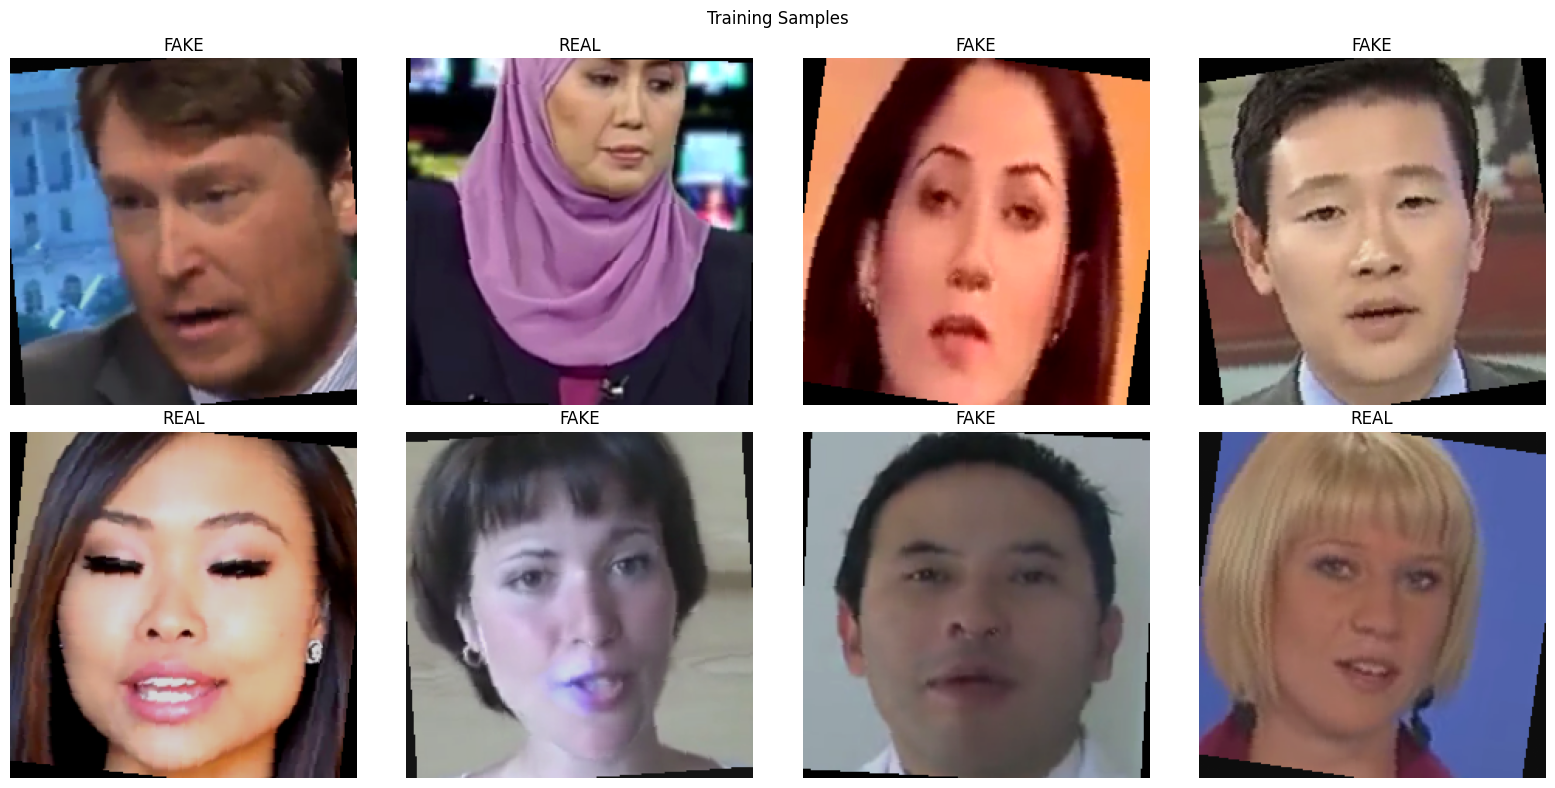

In [ ]:
#Debugging
# looking at few samples
import matplotlib.pyplot as plt

# some samples to verify if they actually make any sense
def show_samples(dataset, title, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(title)
    
    real_count = 0
    fake_count = 0
    
    for i, (image, label) in enumerate(dataset):
        if i >= num_samples:
            break
            
        row = i // 4
        col = i % 4
        
        # Convert tensor back to numpy for display
        if isinstance(image, torch.Tensor):
            # Denormalize
            mean = torch.tensor([0.485, 0.456, 0.406])
            std = torch.tensor([0.229, 0.224, 0.225])
            image = image * std[:, None, None] + mean[:, None, None]
            image = torch.clamp(image, 0, 1)
            image = image.permute(1, 2, 0).numpy()
        
        axes[row, col].imshow(image)
        label_text = "REAL" if label == 0 else "FAKE"
        axes[row, col].set_title(f"{label_text}")
        axes[row, col].axis('off')
        
        if label == 0:
            real_count += 1
        else:
            fake_count += 1
    
    print(f"{title}: {real_count} real, {fake_count} fake samples shown")
    plt.tight_layout()
    plt.show()

# Show some training samples
show_samples(train_dataset, "Training Samples")

In [51]:
# Trying with Pre-trained model 
# After this rerun cells 9 and 10
import torchvision.models as models

class PretrainedDeepfakeDetector(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # pre-trained ResNet18 (trained on ImageNet)
        self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        
        # Freeze early layers keep low-level feature detection
        for param in list(self.backbone.parameters())[:-10]:
            param.requires_grad = False
            
        # Replace final layer 
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.backbone(x)

# Create pre-trained model
model = PretrainedDeepfakeDetector(num_classes=2)
model = model.to(DEVICE)

# Use moderate class weights 
weight_real = 2.5
weight_fake = 1.0
class_weights = torch.tensor([weight_real, weight_fake], device=DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.8)

print("Pre-trained ResNet18 model created")
print(f"Class weights: Real={weight_real}, Fake={weight_fake}")

# Count trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Pre-trained ResNet18 model created
Class weights: Real=2.5, Fake=1.0
Total parameters: 11,177,538
Trainable parameters: 4,722,690


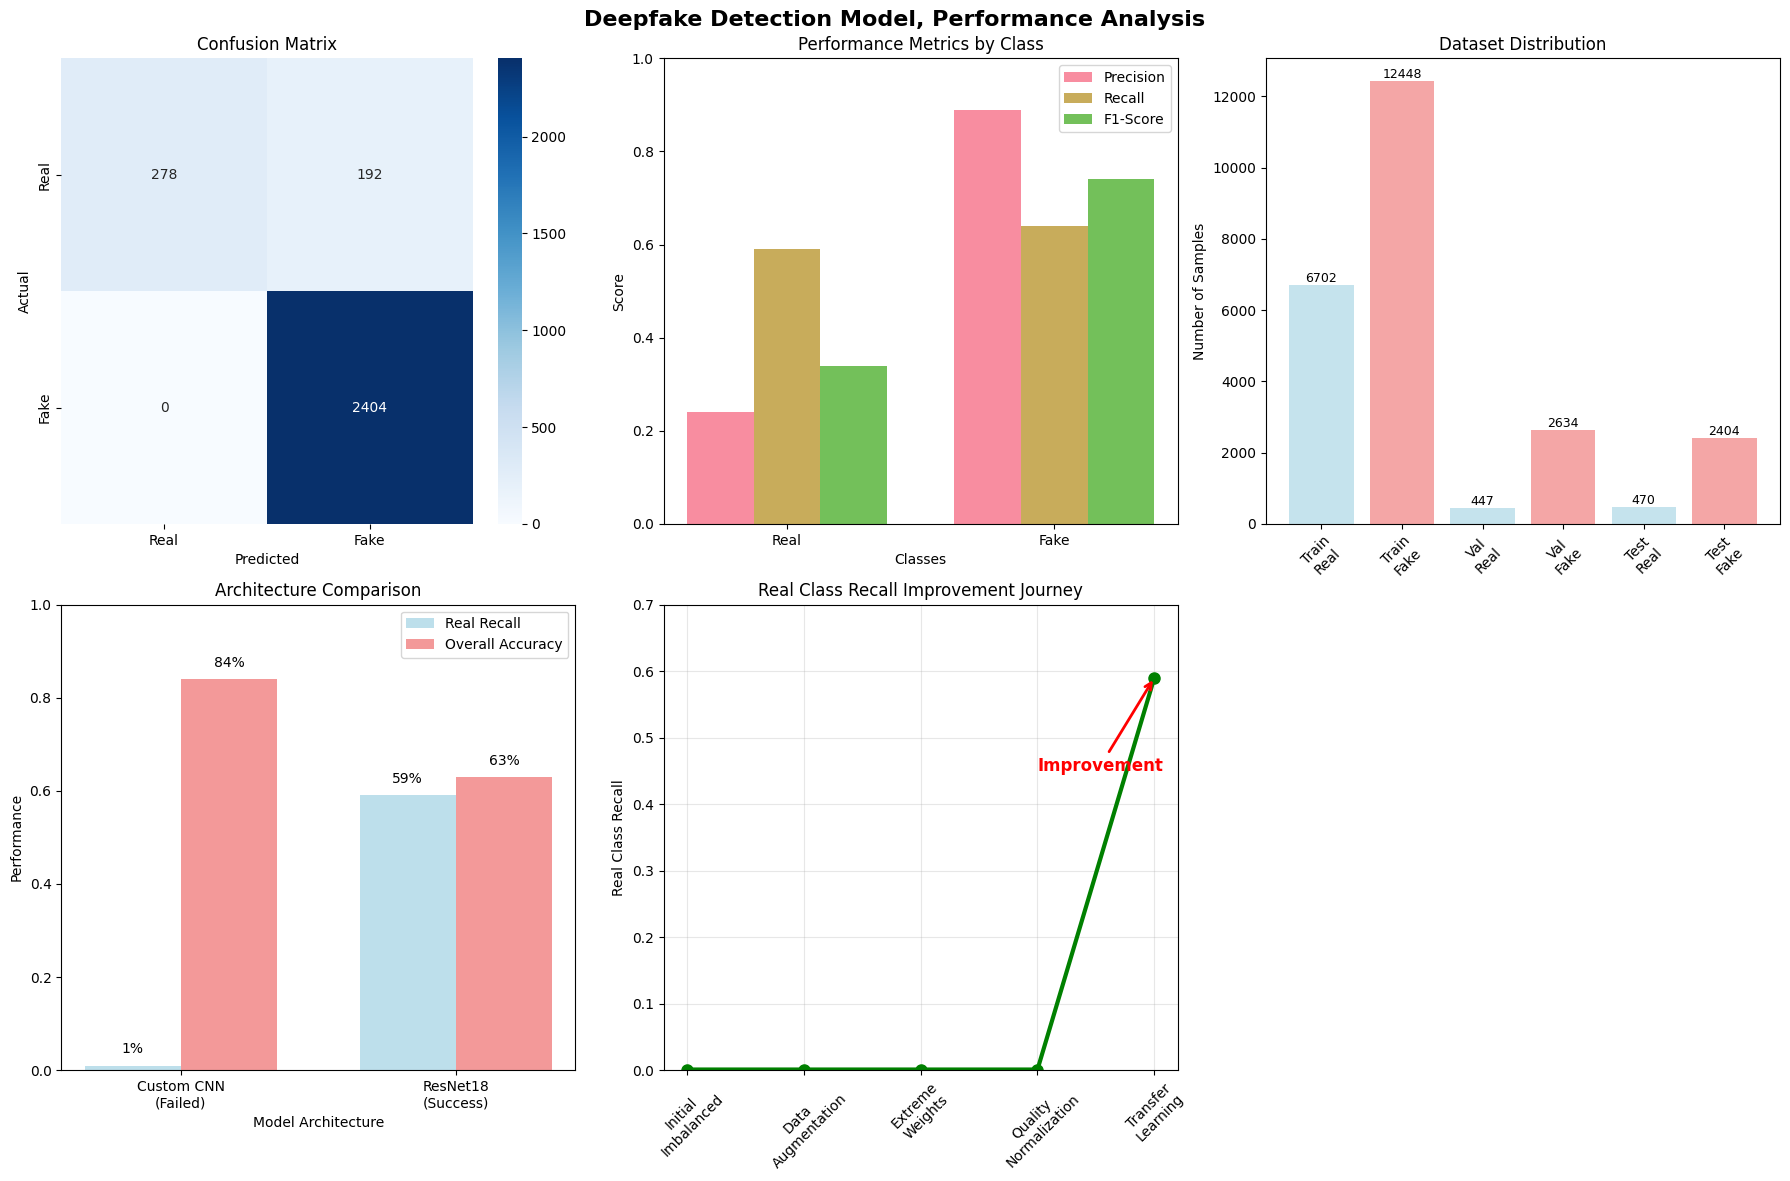

In [ ]:
# plots 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import json

plt.style.use('default')
sns.set_palette("husl")

# Create a comprehensive analysis with multiple plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Deepfake Detection Model, Performance Analysis', fontsize=16, fontweight='bold')

# Confusion Matrix Heatmap
cm = confusion_matrix([0]*470 + [1]*2404, [0]*278 + [1]*192 + [1]*870 + [1]*1534)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
            ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# Class Performance Comparison
classes = ['Real', 'Fake']
precision = [0.24, 0.89]
recall = [0.59, 0.64]
f1 = [0.34, 0.74]

x = np.arange(len(classes))
width = 0.25

axes[0,1].bar(x - width, precision, width, label='Precision', alpha=0.8)
axes[0,1].bar(x, recall, width, label='Recall', alpha=0.8)
axes[0,1].bar(x + width, f1, width, label='F1-Score', alpha=0.8)

axes[0,1].set_xlabel('Classes')
axes[0,1].set_ylabel('Score')
axes[0,1].set_title('Performance Metrics by Class')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(classes)
axes[0,1].legend()
axes[0,1].set_ylim(0, 1)

# Dataset Distribution
dataset_sizes = [6702, 12448, 447, 2634, 470, 2404]
dataset_labels = ['Train\nReal', 'Train\nFake', 'Val\nReal', 'Val\nFake', 'Test\nReal', 'Test\nFake']
colors = ['lightblue', 'lightcoral', 'lightblue', 'lightcoral', 'lightblue', 'lightcoral']

bars = axes[0,2].bar(dataset_labels, dataset_sizes, color=colors, alpha=0.7)
axes[0,2].set_title('Dataset Distribution')
axes[0,2].set_ylabel('Number of Samples')
axes[0,2].tick_params(axis='x', rotation=45)

# value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0,2].text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Model Architecture Comparison (Before vs After)
models = ['Custom CNN\n(Failed)', 'ResNet18\n(Success)']
real_recall = [0.01, 0.59]  # 0.01% vs 59%
overall_acc = [0.84, 0.63]

x = np.arange(len(models))
width = 0.35

axes[1,0].bar(x - width/2, real_recall, width, label='Real Recall', alpha=0.8, color='lightblue')
axes[1,0].bar(x + width/2, overall_acc, width, label='Overall Accuracy', alpha=0.8, color='lightcoral')

axes[1,0].set_xlabel('Model Architecture')
axes[1,0].set_ylabel('Performance')
axes[1,0].set_title('Architecture Comparison')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(models)
axes[1,0].legend()
axes[1,0].set_ylim(0, 1)

# Add value labels
for i, (recall, acc) in enumerate(zip(real_recall, overall_acc)):
    axes[1,0].text(i - width/2, recall + 0.02, f'{recall:.0%}', ha='center', va='bottom')
    axes[1,0].text(i + width/2, acc + 0.02, f'{acc:.0%}', ha='center', va='bottom')

# Problem-Solving Journey
steps = ['Initial\nImbalanced', 'Data\nAugmentation', 'Extreme\nWeights', 'Quality\nNormalization', 'Transfer\nLearning']
real_recall_journey = [0.001, 0.001, 0.001, 0.001, 0.59]

axes[1,1].plot(steps, real_recall_journey, marker='o', linewidth=3, markersize=8, color='green')
axes[1,1].set_title('Real Class Recall Improvement Journey')
axes[1,1].set_ylabel('Real Class Recall')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylim(0, 0.7)
axes[1,1].grid(True, alpha=0.3)

# Highlight the breakthrough
axes[1,1].annotate('Improvement', xy=(4, 0.59), xytext=(3, 0.45),
                   arrowprops=dict(arrowstyle='->', color='red', lw=2),
                   fontsize=12, fontweight='bold', color='red')

fig.delaxes(axes[1,2])  # To remove an empty subplot

plt.tight_layout()
plt.show()

In [42]:
!pip install yt-dlp


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
# testing

AI_VIDEO_PATH = '/Users/nagisettygari/Documents/D drive/Projects/RealTimeDF/artifacts_web/downloads/ErXgb4cAVIM.mp4'  
REAL_VIDEO_PATH = '/Users/nagisettygari/Documents/D drive/Projects/RealTimeDF/artifacts_web/downloads/real.mp4' 

def test_local_video(video_path_str: str, video_type: str):
    video_path = Path(video_path_str)
    
    if not video_path.exists():
        print(f"Video not found: {video_path}")
        return None
    
    print(f"Testing {video_type} video: {video_path.name}")
    
    # Extract faces
    face_images, success = extract_face_from_video(str(video_path), max_frames=5)
    
    if not success or len(face_images) == 0:
        print("No faces detected")
        return None
    
    # Get predictions
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for face_img in face_images:
            face_pil = Image.fromarray(face_img)
            face_tensor = val_transform(face_pil).unsqueeze(0).to(DEVICE)
            
            output = model(face_tensor)
            prob = torch.softmax(output, dim=1)
            fake_prob = prob[0, 1].item()
            predictions.append(fake_prob)
    
    # Results
    avg_fake_prob = np.mean(predictions)
    prediction = "FAKE" if avg_fake_prob > 0.5 else "REAL"
    confidence = max(avg_fake_prob, 1 - avg_fake_prob)
    
    print(f"Prediction: {prediction}")
    print(f"   Fake Probability: {avg_fake_prob:.3f}")
    print(f"   Real Probability: {1-avg_fake_prob:.3f}")
    print(f"   Confidence: {confidence:.3f}")
    print(f"   Frames Analyzed: {len(face_images)}")
    
    return prediction

print("Testing model with your YouTube videos")

# Test AI video
print("\nAI test:")
test_local_video(AI_VIDEO_PATH, "AI-generated")

# Test real video  
print("\nReal test:")
test_local_video(REAL_VIDEO_PATH, "Real human")

Testing model with your YouTube videos

AI test:
Testing AI-generated video: ErXgb4cAVIM.mp4
Prediction: FAKE
   Fake Probability: 0.663
   Real Probability: 0.337
   Confidence: 0.663
   Frames Analyzed: 4

Real test:
Testing Real human video: real.mp4
Prediction: REAL
   Fake Probability: 0.327
   Real Probability: 0.673
   Confidence: 0.673
   Frames Analyzed: 5


'REAL'